# Algorithm Cage Match

This notebook generates sets of fake STTCs from PTCs, and determines the mean square error produced by TEPs-I, Bagheri and my count matching algorithms.

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['apikey']

In [4]:
rdr = reader.Reader(vol_conn)
rdr.read()
gf.get_growth_factors(rdr)

In [6]:
ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
nb.find_neighbours()

Prune any STTCs that have the same count ID as a PTC.

In [14]:
common_count_ids = list(set(rdr.ptcs.keys()).intersection(set(rdr.sttcs.keys())))
for count_id in common_count_ids:
    del rdr.sttcs[count_id]

In [15]:
list(set(rdr.ptcs.keys()).intersection(set(rdr.sttcs.keys())))

[]

## Population analysis

In [56]:
sttc_n_years = [len(x.data.index.levels[0]) for x in rdr.sttcs.values()]
ptc_n_years = [len(x.data['AADT'].index) for x in rdr.ptcs.values()]

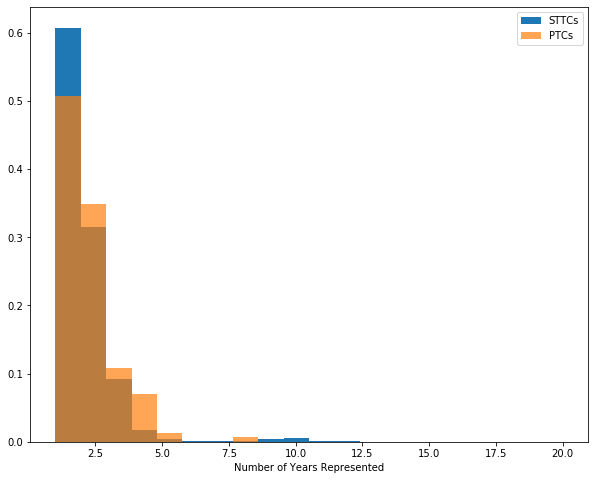

In [67]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_n_years, bins=20, range=(1, 20), density=True, label='STTCs');
ax.hist(ptc_n_years, bins=20, range=(1, 20), density=True, alpha=0.7, label='PTCs')
ax.legend(loc=1)
ax.set_xlabel("Number of Years Represented");

In [69]:
sttc_dyears = [max(x.data.index.levels[0]) - min(x.data.index.levels[0]) for x in rdr.sttcs.values()]
ptc_dyears = [max(x.data['AADT'].index) - min(x.data['AADT'].index) for x in rdr.ptcs.values()]

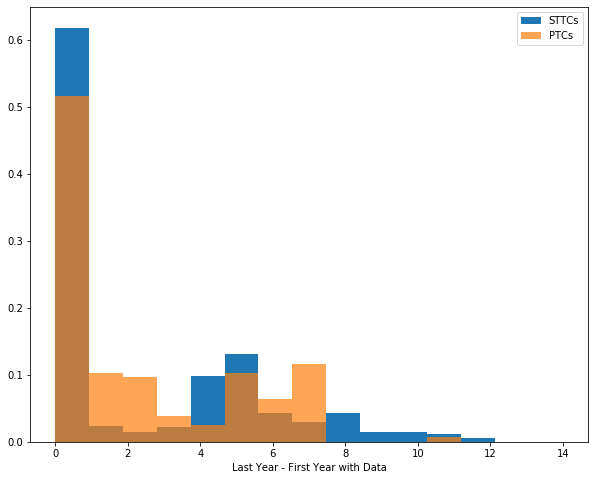

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(sttc_dyears, bins=15, range=(0, 14), density=True, label='STTCs');
ax.hist(ptc_dyears, bins=15, range=(0, 14), density=True, alpha=0.7, label='PTCs')
ax.legend(loc=1)
ax.set_xlabel("Last Year - First Year with Data");

## STTC-MC generator

This routine randomly generates a set of STTCs.  The goal is to generate a set of short term counts that have roughly the same monthly and day-of-month properties as the true short term count data, but are drawn from a sample where true AADTs can be calculated.  The procedure is:

- Cycle through PTCs.  For each PTC:
  - Find an STTC, and determine the number of AADTs we can map to it.
  - 